# Use wav2vec's pre-trained models to do voice recognition.

The following depicts the voice recognition process.


-- From an audio waveform, extract the acoustic characteristics.

-- Estimate the class of the acoustic characteristics frame-by-frame

-- Produce a hypothesis based on the sequence of class probabilities.

Torchaudio makes it simple to obtain pre-trained weights and related data like predicted sample rate and class labels. They're all packed together and accessible through the torchaudio.pipelines() module.

In [1]:
import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

#SPEECH_URL = "/content/drive/MyDrive/Datasets/Speech Recognition/audio.wav"  # noqa: E501
SPEECH_FILE = r"E:/InternshipWork/SpeechDetectionSystemsProject/Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav"

if not os.path.exists(SPEECH_FILE):
        print("File not found!")
else:
    print("File exists.")

2.6.0+cpu
2.6.0+cpu
cpu
File exists.


To begin, we'll build a Wav2Vec2 model that will conduct feature extraction and categorization.

In torchaudio, there are two types of Wav2Vec2 pre-trained weights. The ones that have been fine-tuned for ASR tasks and the ones that have not been fine-tuned.

Self-supervised training is used to train Wav2Vec2 (and HuBERT) models. They are first trained for representation learning using simply audio, and then fine-tuned for a given job using additional labels.

The pre-trained weights may be fine-tuned for other downstream jobs as well, although it is not covered in this tutorial.

In this case, we'll call torchaudio.pipelines.WAV2VEC2 ASR BASE 960H().

As torchaudio.pipelines, you may choose from a variety of models. Please refer to the documentation for further information on how they are educated.

The model and associated information are instantiated using the bundle object.

In [2]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically fetch the pre-trained weights and load it into the model.

In [3]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


The speech data will be taken from the [Open Speech Repository](https://www.voiptroubleshooter.com/open_speech/american.html).

In [4]:
IPython.display.Audio(SPEECH_FILE)

Torchaudio is used to load data

If the sampling rate differs from what the pipeline expects, we may resample with torchaudio.functional.resample().

In [ ]:
#Install neccesary modules

#pip install sox
#pip install torchaudio --no-cache-dir
#pip install torchaudio --index-url https://download.pytorch.org/whl/cu118
#pip install torchaudio -c pytorch




In [5]:
import torchaudio
print(torchaudio.list_audio_backends())


['soundfile']


In [6]:
torchaudio.set_audio_backend("sox_io")


C:\Users\Jaya\AppData\Local\Temp\ipykernel_148472\2399394579.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [7]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
print("Loaded successfully!", waveform.shape, sample_rate)


Loaded successfully! torch.Size([1, 37574]) 24414


In [8]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

### Extracting acoustic features
The next step is to extract acoustic features from the audio.
Wav2Vec2 models fine-tuned for ASR task can perform feature extraction and classification with one step, but for the sake of the tutorial, we also show how to perform feature extraction here.

In [9]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

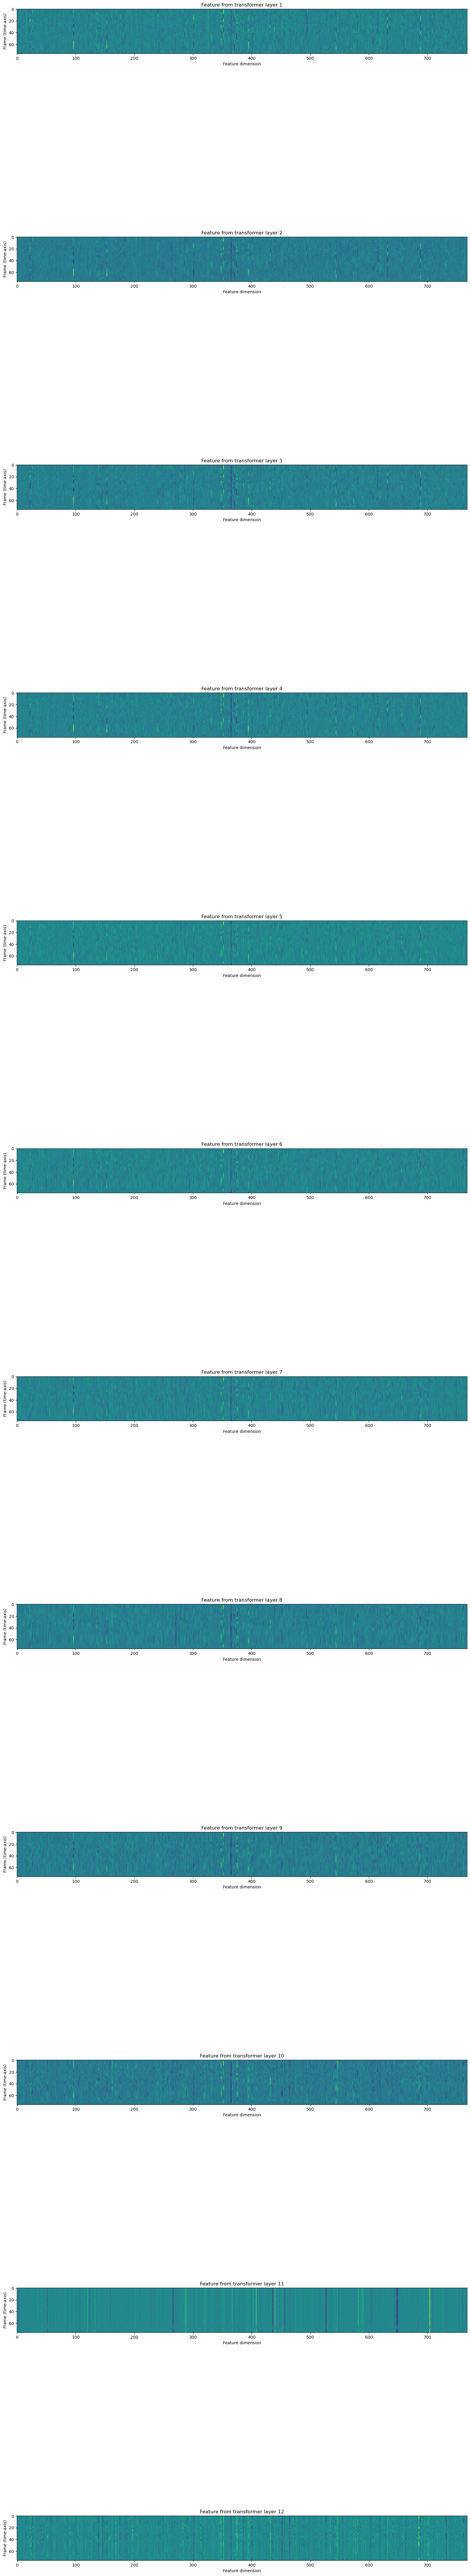

In [10]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 8 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

### Feature classification

Once the acoustic features are extracted, the next step is to classify them into a set of categories.

Wav2Vec2 model provides method to perform the feature extraction and classification in one step.

In [11]:
with torch.inference_mode():
    emission, _ = model(waveform)

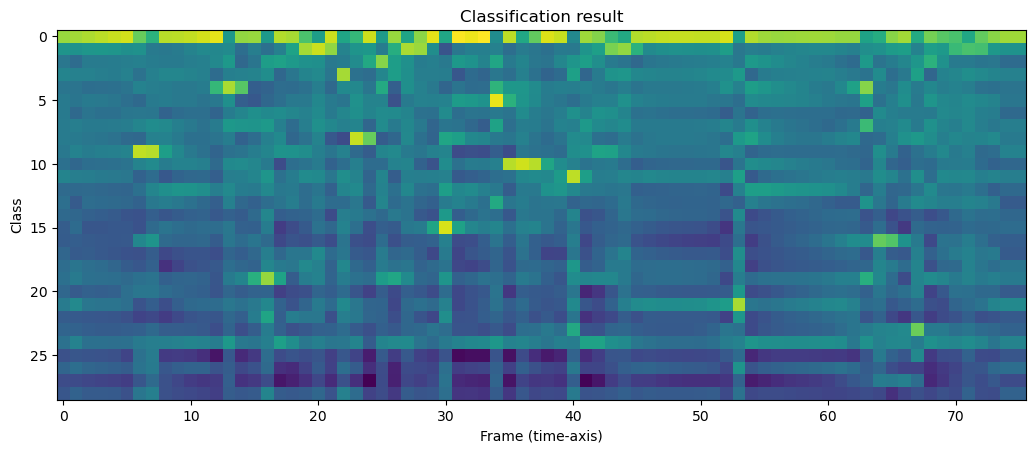

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [12]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

### Generating transcripts

From the sequence of label probabilities, now we want to generate transcripts. The process to generate hypotheses is often called “decoding”.

Decoding is more elaborate than simple classification because decoding at certain time step can be affected by surrounding observations.

In [14]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [15]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [16]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

SAY|THE|WORD|BACK|
